In [1]:
import os
import json
import pandas as pd  # 1.5.0

from rdkit import Chem  # 2023.03.3
from rdkit.Chem.Draw import IPythonConsole, MolToImage
from rdkit.Chem.rdmolops import GetDistanceMatrix
from tqdm import tqdm
import matplotlib.pyplot as plt

from collections import defaultdict, Counter
import statistics

from structure_functions import *

# Deactivate rdkit messages:
from rdkit import RDLogger   
RDLogger.DisableLog("rdApp.*")

DATA_DIRECTORY_PATH = os.path.join((os.path.split(os.getcwd())[0]), "data")

/home/filip/Projekte/mulksgrp/fia_gnn_greb/substructure_and_ringsystem_analysis/structure_functions.py:301: SyntaxWarning: invalid escape sequence '\['
  smiles = re.sub("(\[)([a-zA-Z]{1,2})(H|H[2-9])?(\:1000\])", "*", smiles)


# 0. Load dataset

In [2]:
# import dataset:
df = pd.read_csv(os.path.join(DATA_DIRECTORY_PATH, "FIA49k.csv"))
df.shape

# filter dataset:
df = df[df["mol_type"] == "fia44k"]

print(f"Compounds in Dataset: {len(df)}")

Compounds in Dataset: 44877


In [5]:
def draw_boxplots(vals, labels, xlabel = "", ylabel = "", title = "", size = None, save_as = None):
    if size is not None:
        plt.figure().set_figheight(size)
    plt.boxplot(vals, vert = False, labels = labels)
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if save_as is not None:
        plt.savefig(save_as)
    plt.show()

def get_shortest_distance(sub_smiles, ligand_smiles, central_atom, la_smiles, counter):

    def print_matches(match: bool):
        print("------------------------------------------------------------------------------------------------")
        print(f"{"No m" if not match else "M"}atch!")
        print(f"Ligand mol:")
        display(MolToImage(ligand_mol))
        print(f"LA mol:")
        display(MolToImage(la_mol))
        print(f"Substructure SMILES mol:")
        display(MolToImage(sub_smi_mol))
        print(f"SMILES: {la_smiles}")
        print(f"Substructure SMILES: {sub_smi}")
        
    ligand_mol = Chem.MolFromSmiles(ligand_smiles)
    if ligand_mol.GetNumAtoms() == 1:
        # directly adjacent to central atom
        return [1]
    la_mol = Chem.MolFromSmiles(la_smiles)
    distances = GetDistanceMatrix(la_mol)
    # HACK: speaks for itself...
    # needed since [X,x] notation does not work for i.e. Al
    ca_atomic_num = Chem.MolFromSmarts(f"[{central_atom}]").GetAtomWithIdx(0).GetAtomicNum()
    search_string = f"[#{ca_atomic_num}]"
    ca_index = la_mol.GetSubstructMatch(Chem.MolFromSmarts(search_string))[0]

    res = []
    min_distance = la_mol.GetNumAtoms()
    for sub_smi in sub_smiles:
        sub_smi_mol = Chem.MolFromSmiles(sub_smi)
        p = Chem.AdjustQueryParameters.NoAdjustments()
        p.makeDummiesQueries = True
        sub = Chem.AdjustQueryProperties(sub_smi_mol, p)
        for idx in la_mol.GetSubstructMatch(sub):
            curr_distance = distances[ca_index][idx]
            if curr_distance < min_distance:
                min_distance = curr_distance
        if min_distance == la_mol.GetNumAtoms():
            counter["not_found"] += 1
            if counter["not_found"] >= 20:
                print(counter)
                raise ValueError(f"Too many substructures not found. Aborting.")
            print_matches(False)
        else:
            counter["found"] += 1
            #print_matches(True)
        res.append(min_distance)
    return res

# 1. Analyze substructures of radius 1

### 1.1 Search for substructures

  3%|███▍                                                                                                                              | 1184/44877 [00:02<01:01, 712.63it/s]

------------------------------------------------------------------------------------------------
No match!
Ligand mol:


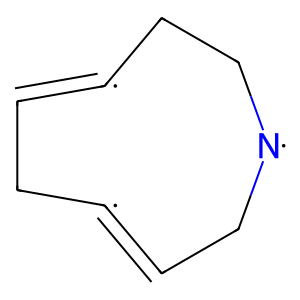

LA mol:


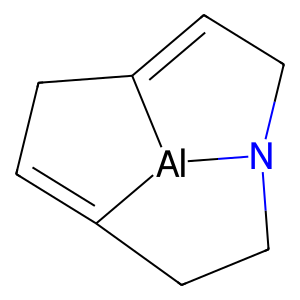

Substructure SMILES mol:


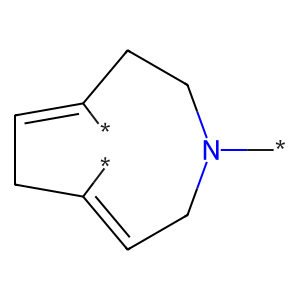

SMILES: [H]C1=C2[Al]3C(=C([H])C([H])([H])N3C([H])([H])C2([H])[H])C1([H])[H]
Substructure SMILES: */C1=C\CN(*)CC/C(*)=C/C1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


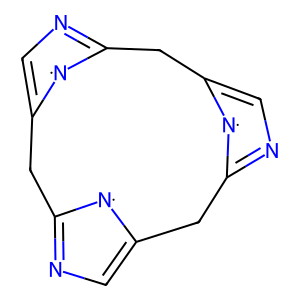

LA mol:


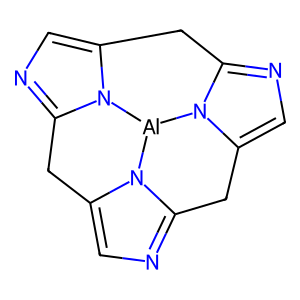

Substructure SMILES mol:


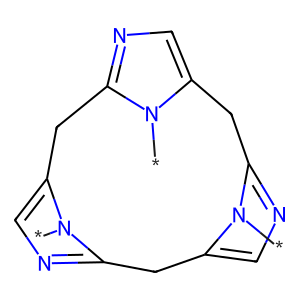

  3%|███▋                                                                                                                              | 1256/44877 [00:02<01:09, 631.20it/s]

SMILES: [H]c1nc2n3c1C([H])([H])c1nc([H])c4n1[Al]3n1c(nc([H])c1C2([H])[H])C4([H])[H]
Substructure SMILES: *n1c2cnc1Cc1cnc(n1*)Cc1cnc(n1*)C2


  3%|███▊                                                                                                                              | 1322/44877 [00:02<01:08, 635.97it/s]

------------------------------------------------------------------------------------------------
No match!
Ligand mol:


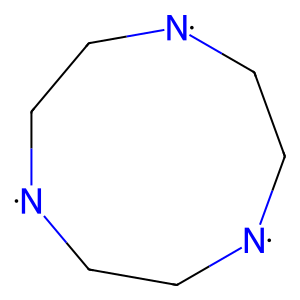

LA mol:


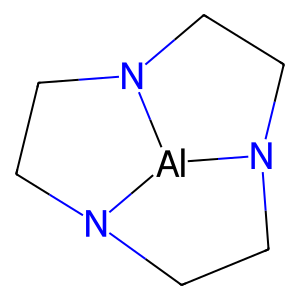

Substructure SMILES mol:


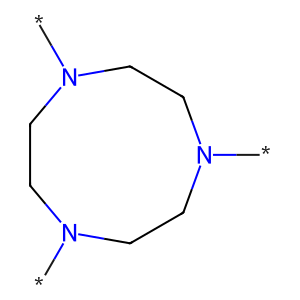

SMILES: [H]C1([H])N2[Al]3N(C1([H])[H])C([H])([H])C([H])([H])N3C([H])([H])C2([H])[H]
Substructure SMILES: *N1CCN(*)CCN(*)CC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


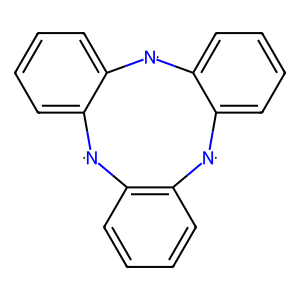

LA mol:


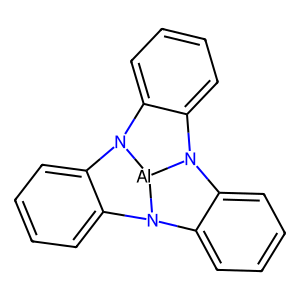

Substructure SMILES mol:


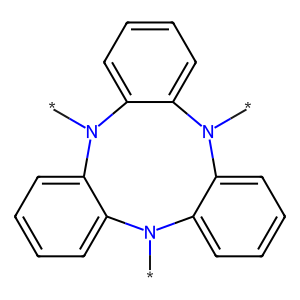

SMILES: [H]c1c([H])c([H])c2c(c1[H])N1c3c([H])c([H])c([H])c([H])c3N3c4c([H])c([H])c([H])c([H])c4N2[Al]13
Substructure SMILES: *N1c2ccccc2N(*)c2ccccc2N(*)c2ccccc21
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


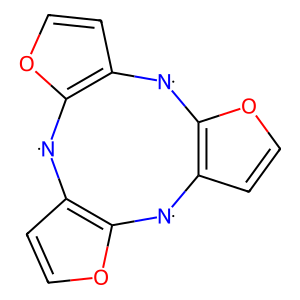

LA mol:


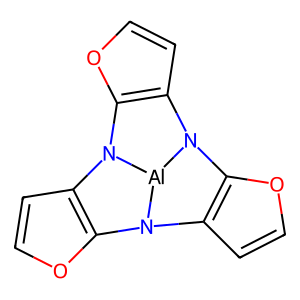

Substructure SMILES mol:


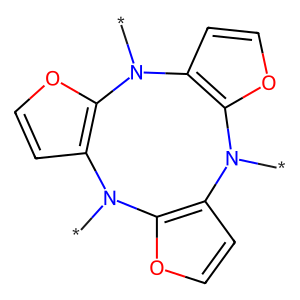

SMILES: [H]c1oc2c(c1[H])N1c3oc([H])c([H])c3N3c4oc([H])c([H])c4N2[Al]13
Substructure SMILES: *N1c2ccoc2N(*)c2ccoc2N(*)c2ccoc21
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


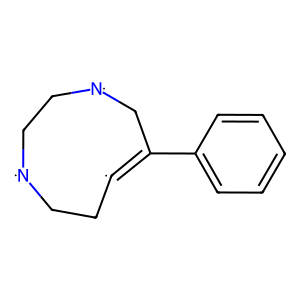

LA mol:


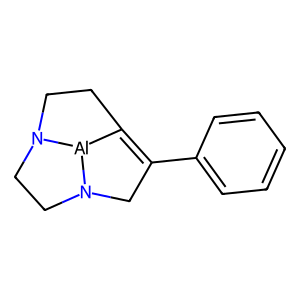

Substructure SMILES mol:


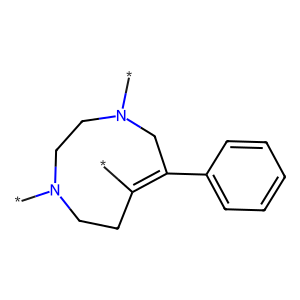

SMILES: [H]c1c([H])c([H])c(C2=C3[Al]4N(C2([H])[H])C([H])([H])C([H])([H])N4C([H])([H])C3([H])[H])c([H])c1[H]
Substructure SMILES: */C1=C(/c2ccccc2)CN(*)CCN(*)CC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


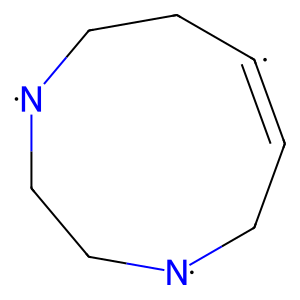

LA mol:


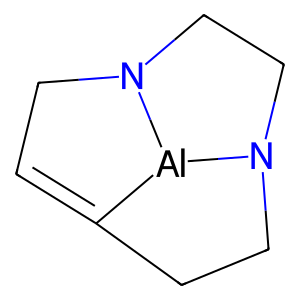

Substructure SMILES mol:


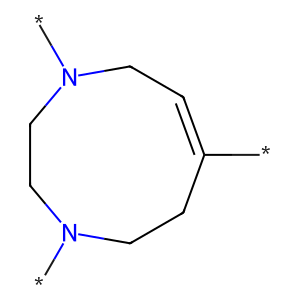

SMILES: [H]C1=C2[Al]3N(C1([H])[H])C([H])([H])C([H])([H])N3C([H])([H])C2([H])[H]
Substructure SMILES: */C1=C/CN(*)CCN(*)CC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


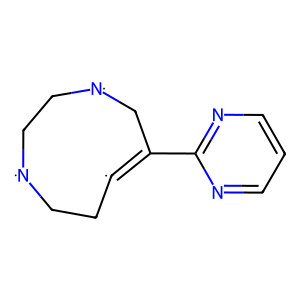

LA mol:


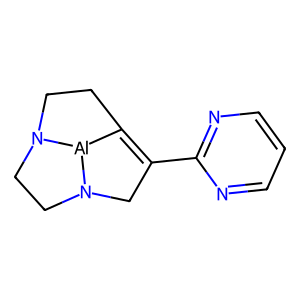

Substructure SMILES mol:


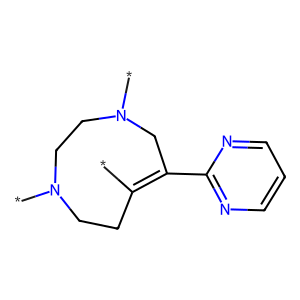

SMILES: [H]c1nc(C2=C3[Al]4N(C2([H])[H])C([H])([H])C([H])([H])N4C([H])([H])C3([H])[H])nc([H])c1[H]
Substructure SMILES: */C1=C(/c2ncccn2)CN(*)CCN(*)CC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


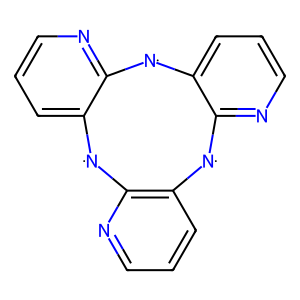

LA mol:


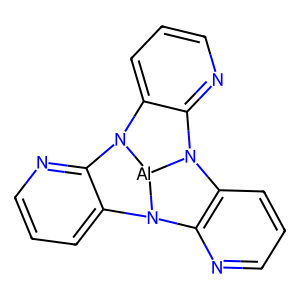

Substructure SMILES mol:


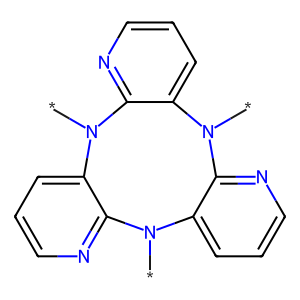

SMILES: [H]c1nc2c(c([H])c1[H])N1c3nc([H])c([H])c([H])c3N3c4nc([H])c([H])c([H])c4N2[Al]13
Substructure SMILES: *N1c2cccnc2N(*)c2cccnc2N(*)c2cccnc21
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


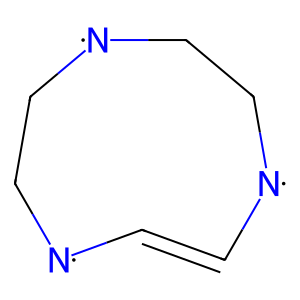

LA mol:


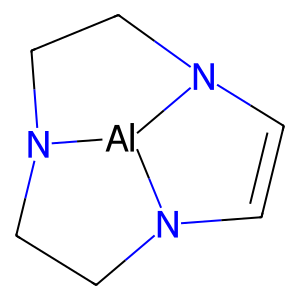

Substructure SMILES mol:


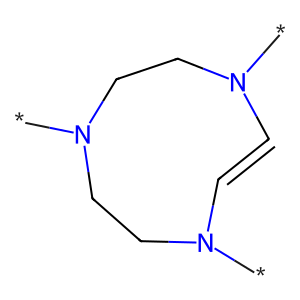

SMILES: [H]C1=C([H])N2[Al]3N1C([H])([H])C([H])([H])N3C([H])([H])C2([H])[H]
Substructure SMILES: *N1/C=C/N(*)CCN(*)CC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


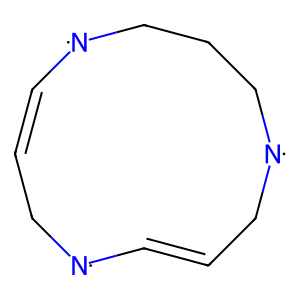

LA mol:


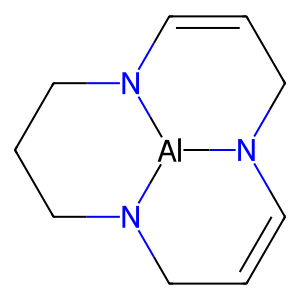

Substructure SMILES mol:


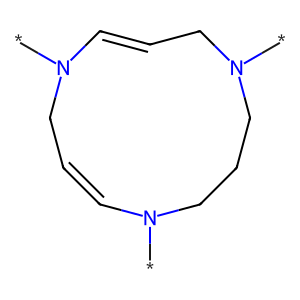

SMILES: [H]C1=C([H])C([H])([H])N2[Al]3N1C([H])([H])C([H])=C([H])N3C([H])([H])C([H])([H])C2([H])[H]
Substructure SMILES: *N1/C=C\CN(*)/C=C/CN(*)CCC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


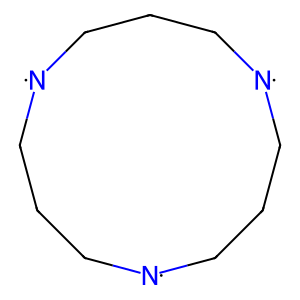

LA mol:


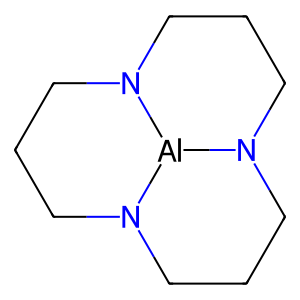

Substructure SMILES mol:


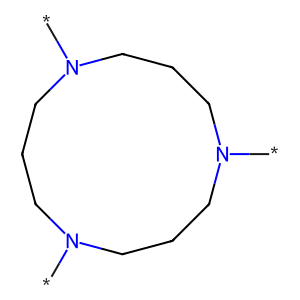

SMILES: [H]C1([H])N2[Al]3N(C([H])([H])C1([H])[H])C([H])([H])C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])C2([H])[H]
Substructure SMILES: *N1CCCN(*)CCCN(*)CCC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


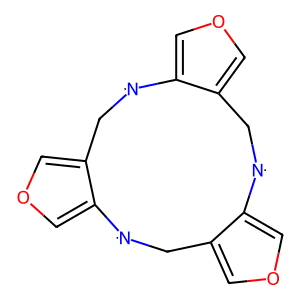

LA mol:


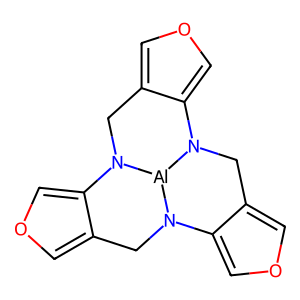

Substructure SMILES mol:


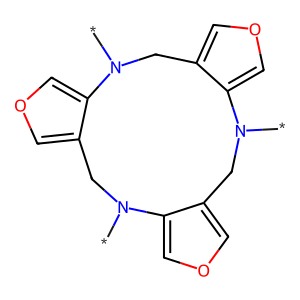

SMILES: [H]c1oc([H])c2c1N1[Al]3N(c4c([H])oc([H])c4C([H])([H])N3c3c([H])oc([H])c3C1([H])[H])C2([H])[H]
Substructure SMILES: *N1Cc2cocc2N(*)Cc2cocc2N(*)Cc2cocc21
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


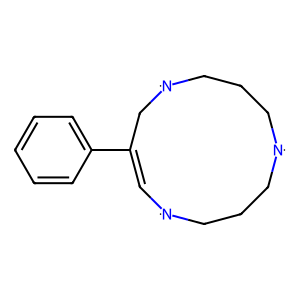

LA mol:


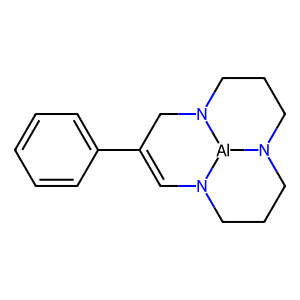

Substructure SMILES mol:


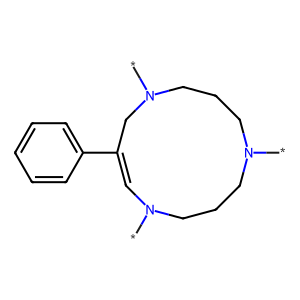

SMILES: [H]C1=C(c2c([H])c([H])c([H])c([H])c2[H])C([H])([H])N2[Al]3N1C([H])([H])C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])C2([H])[H]
Substructure SMILES: *N1/C=C(/c2ccccc2)CN(*)CCCN(*)CCC1


  4%|█████▍                                                                                                                            | 1887/44877 [00:03<01:10, 610.15it/s]

------------------------------------------------------------------------------------------------
No match!
Ligand mol:


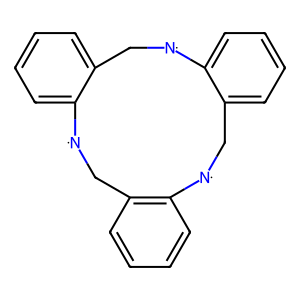

LA mol:


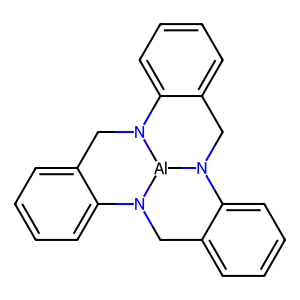

Substructure SMILES mol:


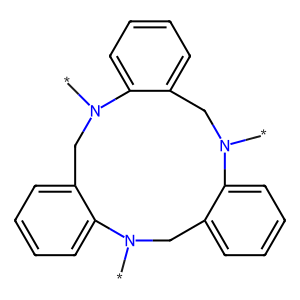

  4%|█████▋                                                                                                                            | 1951/44877 [00:03<01:18, 548.80it/s]

SMILES: [H]c1c([H])c([H])c2c(c1[H])N1[Al]3N(c4c([H])c([H])c([H])c([H])c4C([H])([H])N3c3c([H])c([H])c([H])c([H])c3C1([H])[H])C2([H])[H]
Substructure SMILES: *N1Cc2ccccc2N(*)Cc2ccccc2N(*)Cc2ccccc21
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


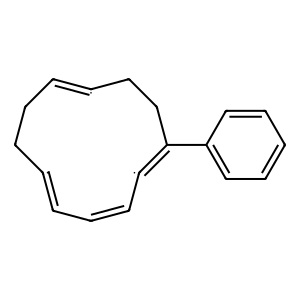

LA mol:


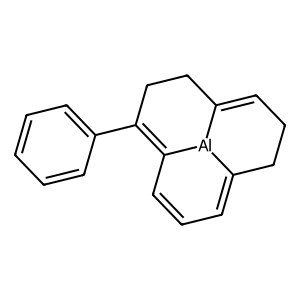

Substructure SMILES mol:


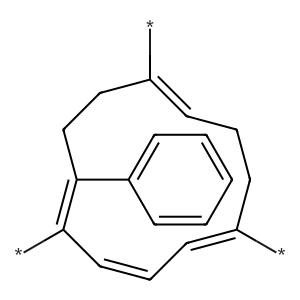

  4%|█████▊                                                                                                                            | 2009/44877 [00:03<01:23, 515.06it/s]

SMILES: [H]C1=C([H])C2=C(c3c([H])c([H])c([H])c([H])c3[H])C([H])([H])C([H])([H])C3=C([H])C([H])([H])C([H])([H])C(=C1[H])[Al]23
Substructure SMILES: *C1=C(/c2ccccc2)CC/C(*)=C/CC/C(*)=C/C=C\1


  5%|█████▉                                                                                                                            | 2063/44877 [00:03<01:26, 495.72it/s]

------------------------------------------------------------------------------------------------
No match!
Ligand mol:


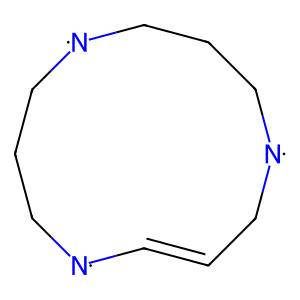

LA mol:


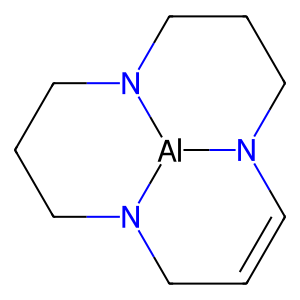

Substructure SMILES mol:


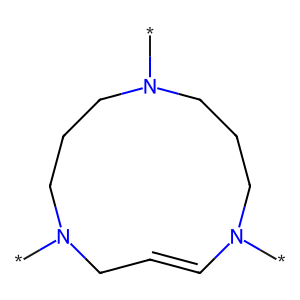

SMILES: [H]C1=C([H])C([H])([H])N2[Al]3N1C([H])([H])C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])C2([H])[H]
Substructure SMILES: *N1/C=C/CN(*)CCCN(*)CCC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


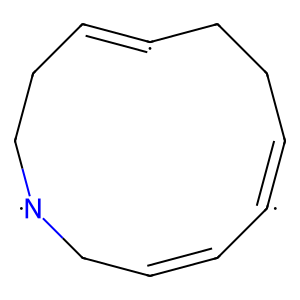

LA mol:


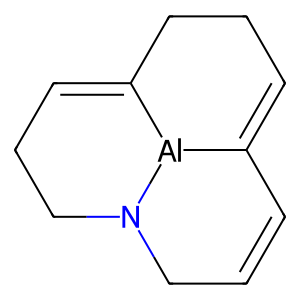

Substructure SMILES mol:


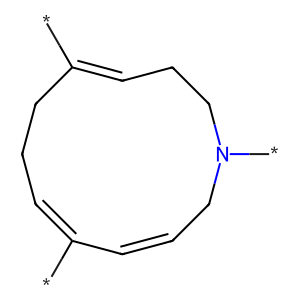

SMILES: [H]C1=C([H])C([H])([H])N2[Al]3C1=C([H])C([H])([H])C([H])([H])C3=C([H])C([H])([H])C2([H])[H]
Substructure SMILES: *C1=C/CC/C(*)=C/CCN(*)C/C=C\1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


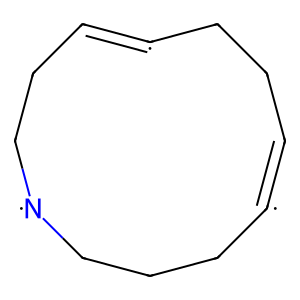

LA mol:


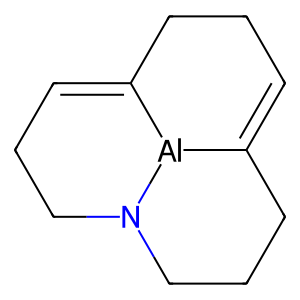

Substructure SMILES mol:


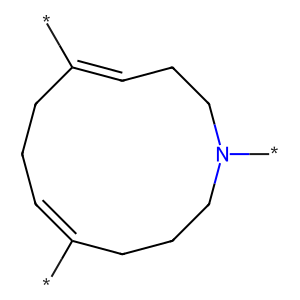

SMILES: [H]C1=C2[Al]3C(=C([H])C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])C2([H])[H])C([H])([H])C1([H])[H]
Substructure SMILES: */C1=C/CC/C(*)=C/CCN(*)CCC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


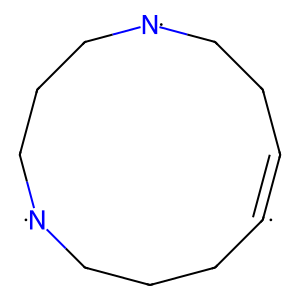

LA mol:


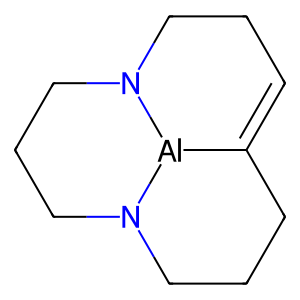

Substructure SMILES mol:


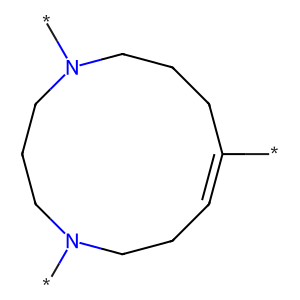

  5%|██████                                                                                                                            | 2114/44877 [00:04<01:38, 433.66it/s]

SMILES: [H]C1=C2[Al]3N(C([H])([H])C1([H])[H])C([H])([H])C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])C2([H])[H]
Substructure SMILES: */C1=C/CCN(*)CCCN(*)CCC1


  7%|█████████▌                                                                                                                        | 3306/44877 [00:06<01:01, 680.77it/s]

------------------------------------------------------------------------------------------------
No match!
Ligand mol:


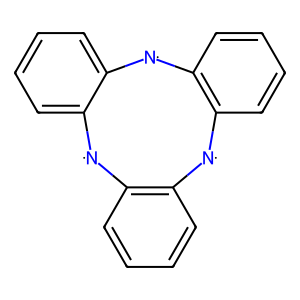

LA mol:


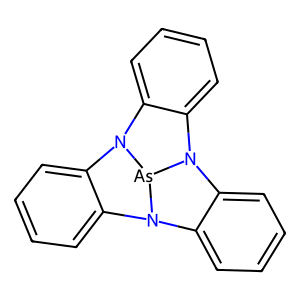

Substructure SMILES mol:


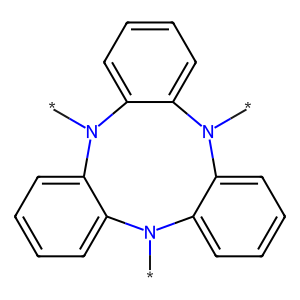

SMILES: [H]c1c([H])c([H])c2c(c1[H])N1c3c([H])c([H])c([H])c([H])c3N3c4c([H])c([H])c([H])c([H])c4N2[As]13
Substructure SMILES: *N1c2ccccc2N(*)c2ccccc2N(*)c2ccccc21
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


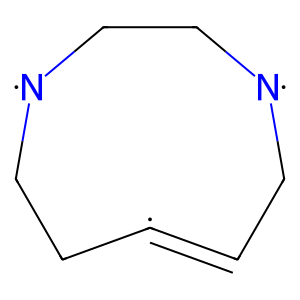

LA mol:


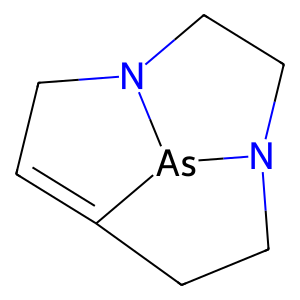

Substructure SMILES mol:


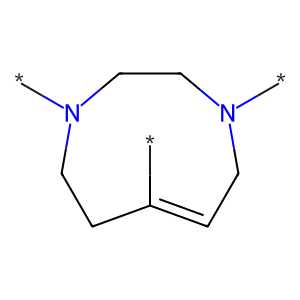

SMILES: [H]C1=C2[As]3N(C1([H])[H])C([H])([H])C([H])([H])N3C([H])([H])C2([H])[H]
Substructure SMILES: */C1=C\CN(*)CCN(*)CC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


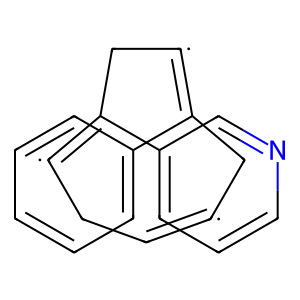

LA mol:


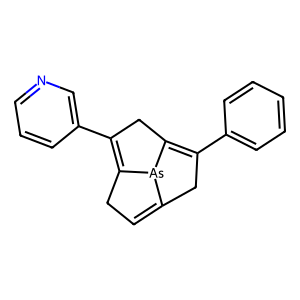

Substructure SMILES mol:


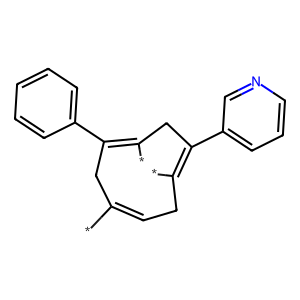

SMILES: [H]C1=C2[As]3C(=C(c4c([H])nc([H])c([H])c4[H])C([H])([H])C3=C(c3c([H])c([H])c([H])c([H])c3[H])C2([H])[H])C1([H])[H]
Substructure SMILES: */C1=C/C/C(*)=C(\c2cccnc2)C/C(*)=C(\c2ccccc2)C1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


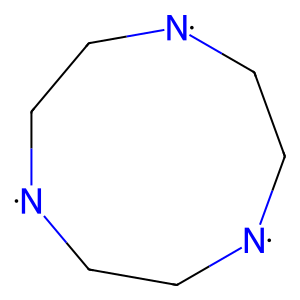

LA mol:


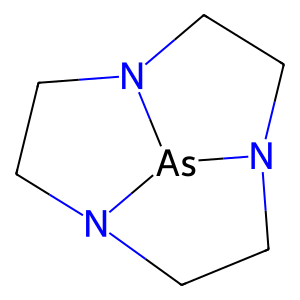

Substructure SMILES mol:


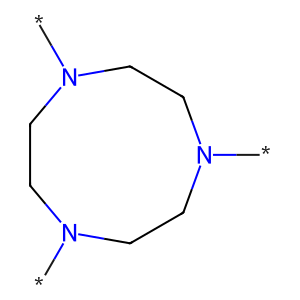

SMILES: [H]C1([H])N2[As]3N(C1([H])[H])C([H])([H])C([H])([H])N3C([H])([H])C2([H])[H]
Substructure SMILES: *N1CCN(*)CCN(*)CC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


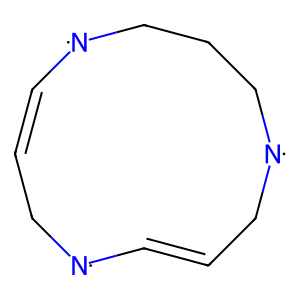

LA mol:


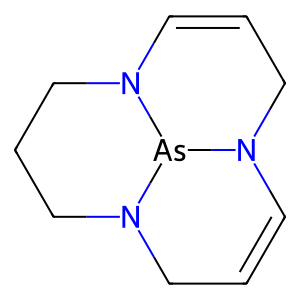

Substructure SMILES mol:


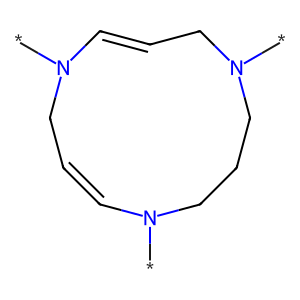

SMILES: [H]C1=C([H])C([H])([H])N2[As]3N1C([H])([H])C([H])=C([H])N3C([H])([H])C([H])([H])C2([H])[H]
Substructure SMILES: *N1/C=C\CN(*)/C=C/CN(*)CCC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


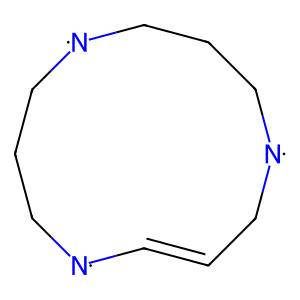

LA mol:


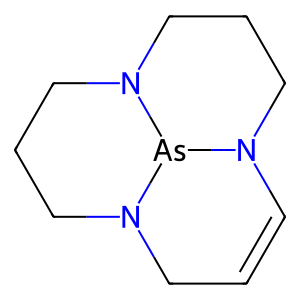

Substructure SMILES mol:


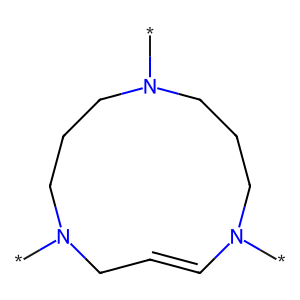

  8%|█████████▊                                                                                                                        | 3375/44877 [00:06<01:23, 497.75it/s]

SMILES: [H]C1=C([H])C([H])([H])N2[As]3N1C([H])([H])C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])C2([H])[H]
Substructure SMILES: *N1/C=C/CN(*)CCCN(*)CCC1


  8%|█████████▉                                                                                                                        | 3448/44877 [00:06<01:15, 550.99it/s]

------------------------------------------------------------------------------------------------
No match!
Ligand mol:


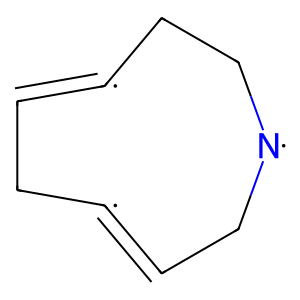

LA mol:


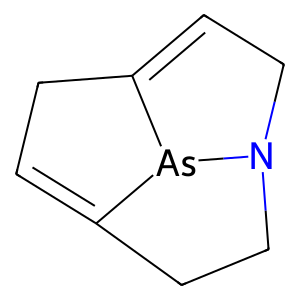

Substructure SMILES mol:


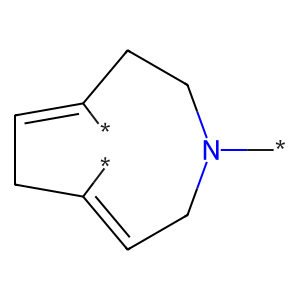

SMILES: [H]C1=C2[As]3C(=C([H])C([H])([H])N3C([H])([H])C2([H])[H])C1([H])[H]
Substructure SMILES: */C1=C\CN(*)CC/C(*)=C/C1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


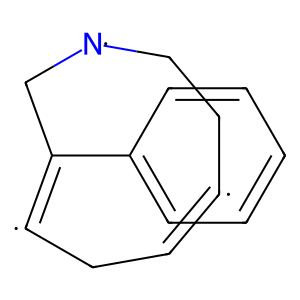

LA mol:


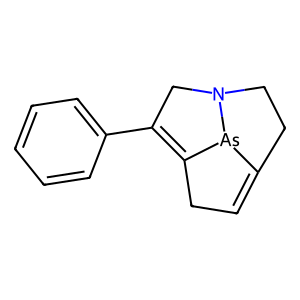

Substructure SMILES mol:


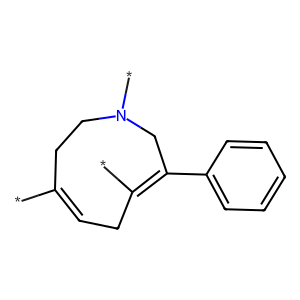

SMILES: [H]C1=C2[As]3C(=C(c4c([H])c([H])c([H])c([H])c4[H])C([H])([H])N3C([H])([H])C2([H])[H])C1([H])[H]
Substructure SMILES: */C1=C/C/C(*)=C(\c2ccccc2)CN(*)CC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


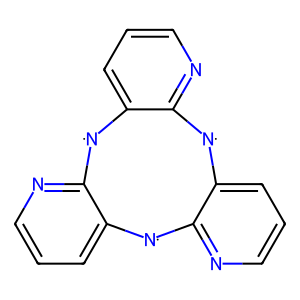

LA mol:


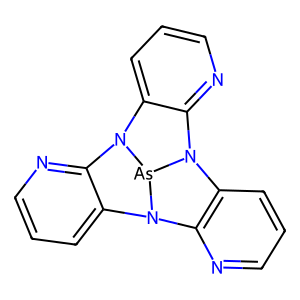

Substructure SMILES mol:


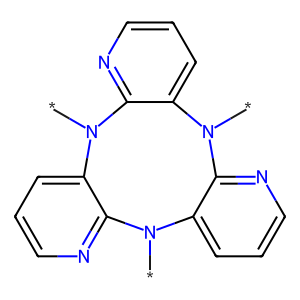

SMILES: [H]c1nc2c(c([H])c1[H])N1c3nc([H])c([H])c([H])c3N3c4nc([H])c([H])c([H])c4N2[As]13
Substructure SMILES: *N1c2cccnc2N(*)c2cccnc2N(*)c2cccnc21
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


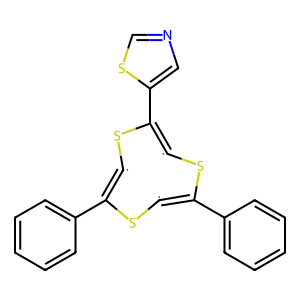

LA mol:


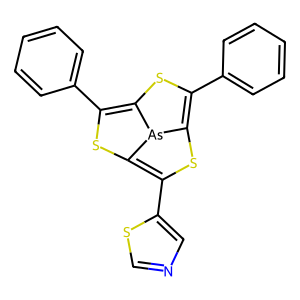

Substructure SMILES mol:


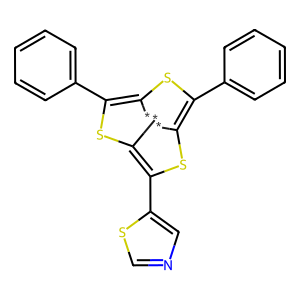

SMILES: [H]c1nc([H])c(C2=C3SC(c4c([H])c([H])c([H])c([H])c4[H])=C4SC(c5c([H])c([H])c([H])c([H])c5[H])=C(S2)[As]34)s1
Substructure SMILES: */C1=C(/c2ccccc2)S/C(*)=C(\c2ccccc2)S/C(*)=C(\c2cncs2)S1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


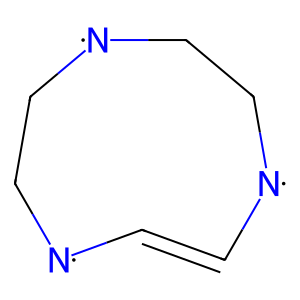

LA mol:


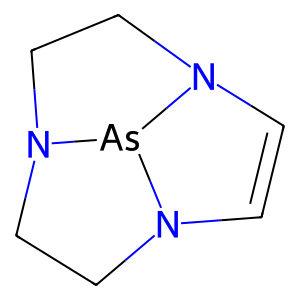

Substructure SMILES mol:


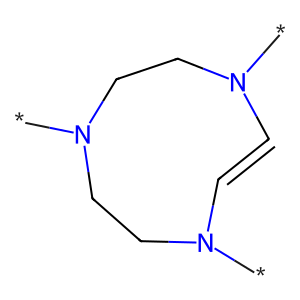

SMILES: [H]C1=C([H])N2[As]3N1C([H])([H])C([H])([H])N3C([H])([H])C2([H])[H]
Substructure SMILES: *N1/C=C/N(*)CCN(*)CC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


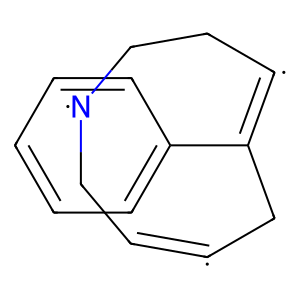

LA mol:


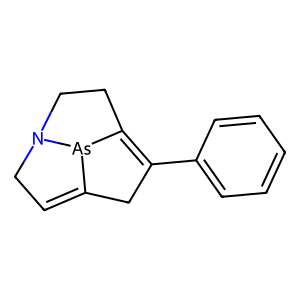

Substructure SMILES mol:


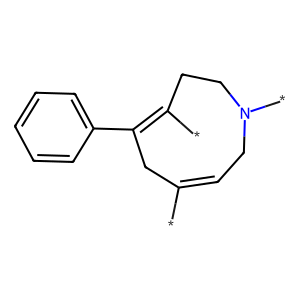

SMILES: [H]C1=C2[As]3C(=C(c4c([H])c([H])c([H])c([H])c4[H])C2([H])[H])C([H])([H])C([H])([H])N3C1([H])[H]
Substructure SMILES: */C1=C/CN(*)CC/C(*)=C(\c2ccccc2)C1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


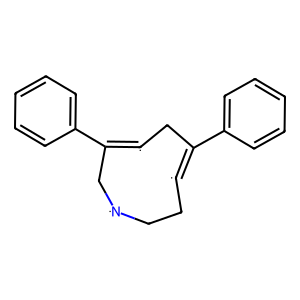

LA mol:


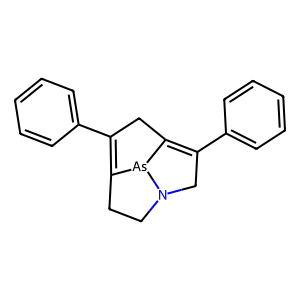

Substructure SMILES mol:


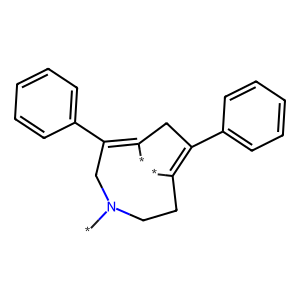

SMILES: [H]c1c([H])c([H])c(C2=C3[As]4C(=C(c5c([H])c([H])c([H])c([H])c5[H])C([H])([H])N4C([H])([H])C3([H])[H])C2([H])[H])c([H])c1[H]
Substructure SMILES: */C1=C(/c2ccccc2)C/C(*)=C(\c2ccccc2)CN(*)CC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


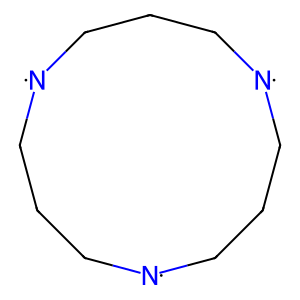

LA mol:


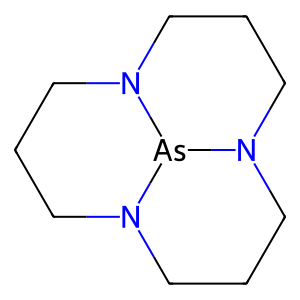

Substructure SMILES mol:


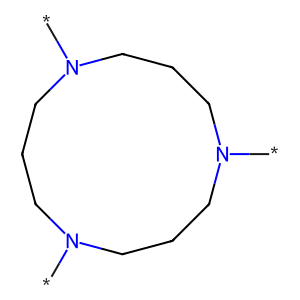

SMILES: [H]C1([H])N2[As]3N(C([H])([H])C1([H])[H])C([H])([H])C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])C2([H])[H]
Substructure SMILES: *N1CCCN(*)CCCN(*)CCC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


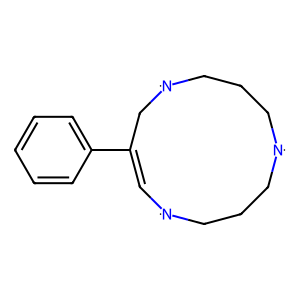

LA mol:


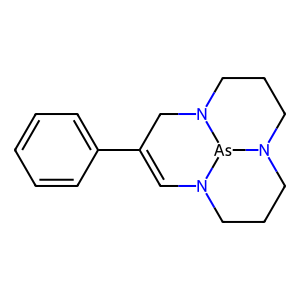

Substructure SMILES mol:


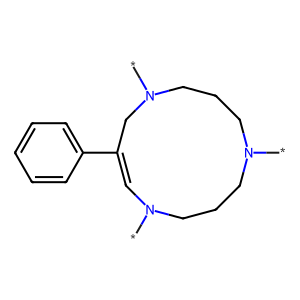

SMILES: [H]C1=C(c2c([H])c([H])c([H])c([H])c2[H])C([H])([H])N2[As]3N1C([H])([H])C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])C2([H])[H]
Substructure SMILES: *N1/C=C(/c2ccccc2)CN(*)CCCN(*)CCC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


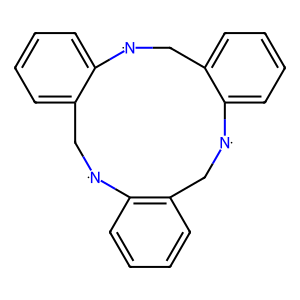

LA mol:


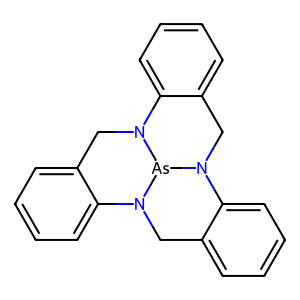

Substructure SMILES mol:


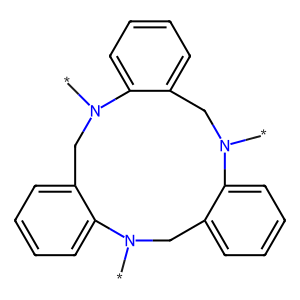

  8%|██████████▏                                                                                                                       | 3510/44877 [00:07<01:53, 365.81it/s]

SMILES: [H]c1c([H])c([H])c2c(c1[H])N1[As]3N(c4c([H])c([H])c([H])c([H])c4C([H])([H])N3c3c([H])c([H])c([H])c([H])c3C1([H])[H])C2([H])[H]
Substructure SMILES: *N1Cc2ccccc2N(*)Cc2ccccc2N(*)Cc2ccccc21
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


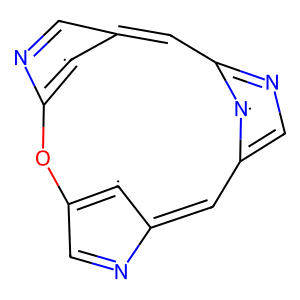

LA mol:


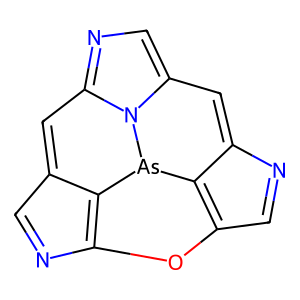

Substructure SMILES mol:


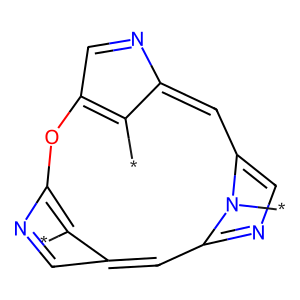

SMILES: [H]C1=NC2=C([H])c3c([H])nc4n3[As]3C5=C(N=C([H])C5=C4[H])OC1=C23
Substructure SMILES: *c1c2cc3cnc(cc4c(*)c(oc1C=N2)N=C4)n3*
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


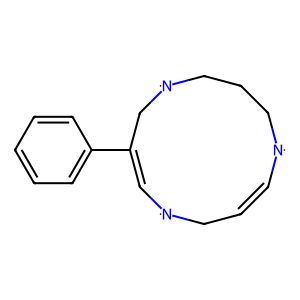

LA mol:


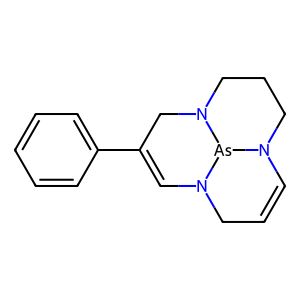

Substructure SMILES mol:


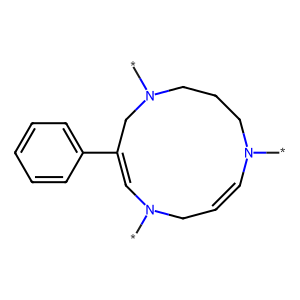

SMILES: [H]C1=C(c2c([H])c([H])c([H])c([H])c2[H])C([H])([H])N2[As]3N1C([H])([H])C([H])=C([H])N3C([H])([H])C([H])([H])C2([H])[H]
Substructure SMILES: *N1/C=C(/c2ccccc2)CN(*)CCCN(*)/C=C\C1


  9%|███████████▌                                                                                                                      | 4001/44877 [00:07<01:07, 605.42it/s]

------------------------------------------------------------------------------------------------
No match!
Ligand mol:


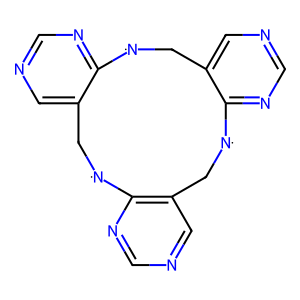

LA mol:


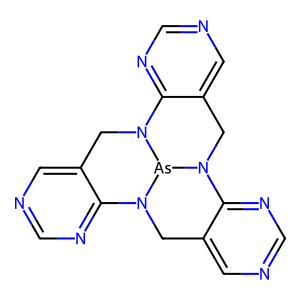

Substructure SMILES mol:


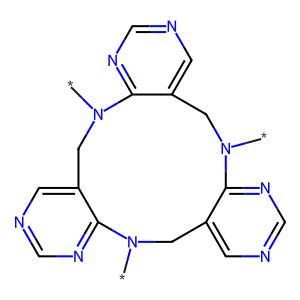

  9%|████████████                                                                                                                      | 4180/44877 [00:08<01:14, 548.58it/s]

SMILES: [H]c1nc([H])c2c(n1)N1[As]3N(c4nc([H])nc([H])c4C([H])([H])N3c3nc([H])nc([H])c3C1([H])[H])C2([H])[H]
Substructure SMILES: *N1Cc2cncnc2N(*)Cc2cncnc2N(*)Cc2cncnc21
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


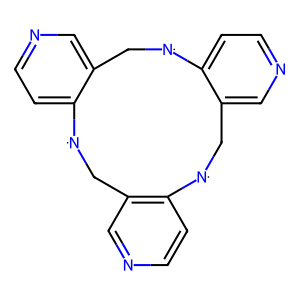

LA mol:


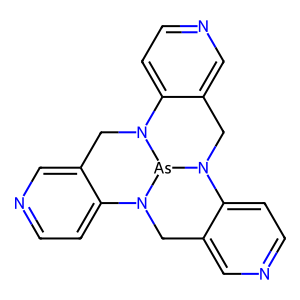

Substructure SMILES mol:


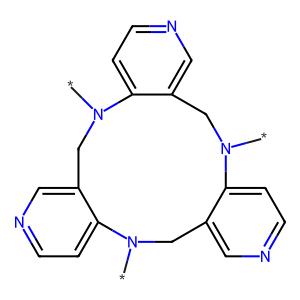

SMILES: [H]c1nc([H])c2c(c1[H])N1[As]3N(c4c([H])c([H])nc([H])c4C([H])([H])N3c3c([H])c([H])nc([H])c3C1([H])[H])C2([H])[H]
Substructure SMILES: *N1Cc2cnccc2N(*)Cc2cnccc2N(*)Cc2cnccc21
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


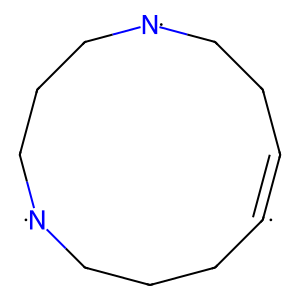

LA mol:


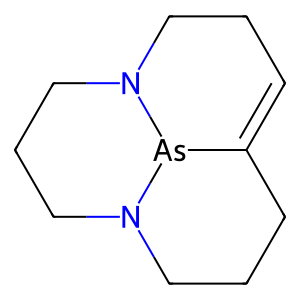

Substructure SMILES mol:


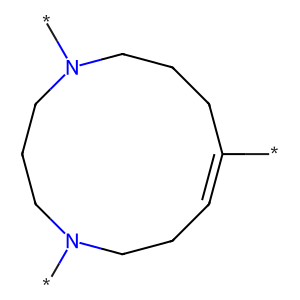

  9%|████████████▎                                                                                                                     | 4237/44877 [00:08<01:25, 473.68it/s]

SMILES: [H]C1=C2[As]3N(C([H])([H])C1([H])[H])C([H])([H])C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])C2([H])[H]
Substructure SMILES: */C1=C/CCN(*)CCCN(*)CCC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


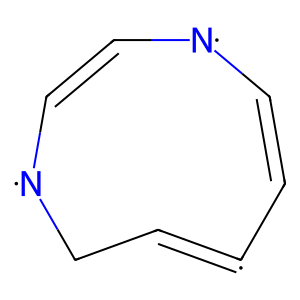

LA mol:


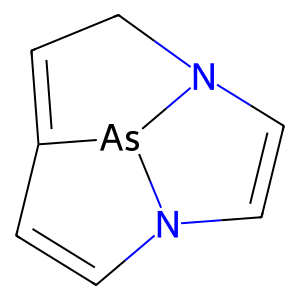

Substructure SMILES mol:


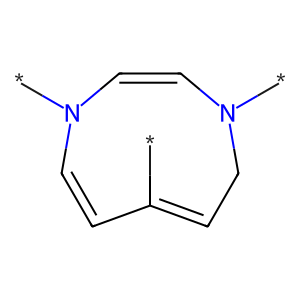

SMILES: [H]C1=C([H])N2C([H])=C([H])N3[As]2C1=C([H])C3([H])[H]
Substructure SMILES: *C1=C\CN(*)/C=C\N(*)/C=C\1


 12%|███████████████▉                                                                                                                  | 5513/44877 [00:12<01:33, 419.96it/s]

------------------------------------------------------------------------------------------------
No match!
Ligand mol:


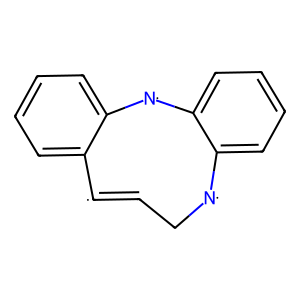

LA mol:


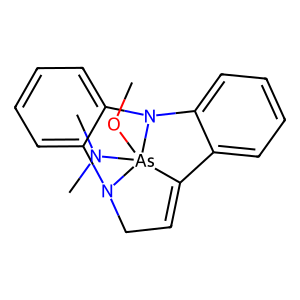

Substructure SMILES mol:


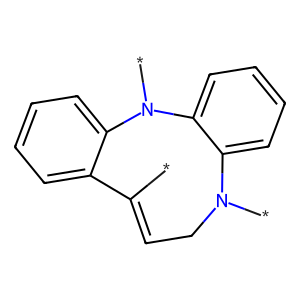

SMILES: [H]C1=C2c3c([H])c([H])c([H])c([H])c3N3c4c([H])c([H])c([H])c([H])c4N(C1([H])[H])[As]23(OC([H])([H])[H])N(C([H])([H])[H])C([H])([H])[H]
Substructure SMILES: */C1=C\CN(*)c2ccccc2N(*)c2ccccc21
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


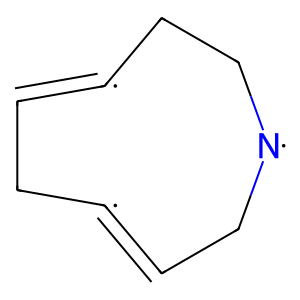

LA mol:


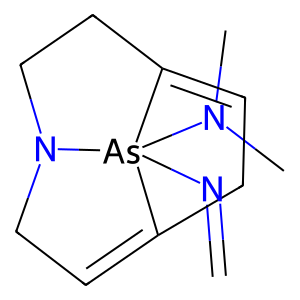

Substructure SMILES mol:


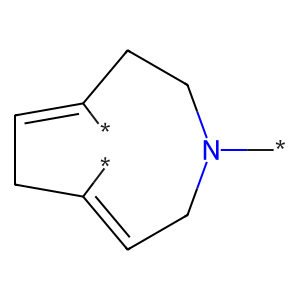

SMILES: [H]C([H])=N[As]12(N(C([H])([H])[H])C([H])([H])[H])C3=C([H])C([H])([H])N1C([H])([H])C([H])([H])C2=C([H])C3([H])[H]
Substructure SMILES: */C1=C\CN(*)CC/C(*)=C/C1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


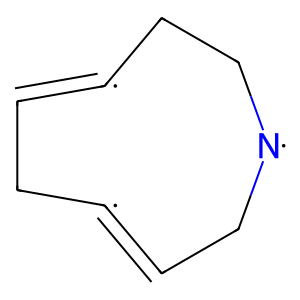

LA mol:


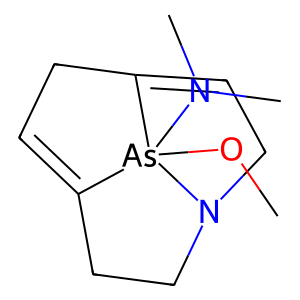

Substructure SMILES mol:


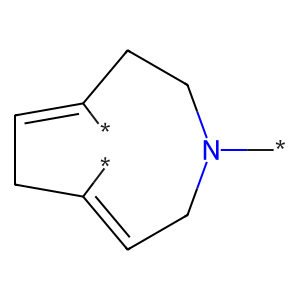

SMILES: [H]C1=C2C([H])([H])C([H])([H])N3C([H])([H])C([H])=C(C1([H])[H])[As]23(OC([H])([H])[H])N(C([H])([H])[H])C([H])([H])[H]
Substructure SMILES: */C1=C\CN(*)CC/C(*)=C/C1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


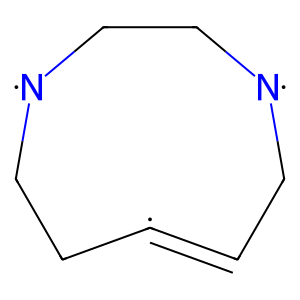

LA mol:


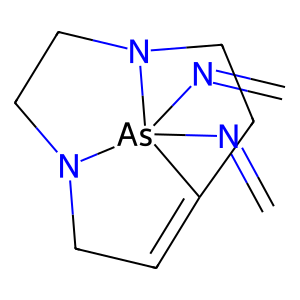

Substructure SMILES mol:


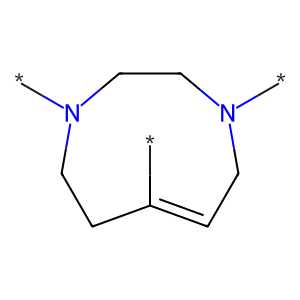

SMILES: [H]C([H])=N[As]12(N=C([H])[H])C3=C([H])C([H])([H])N1C([H])([H])C([H])([H])N2C([H])([H])C3([H])[H]
Substructure SMILES: */C1=C\CN(*)CCN(*)CC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


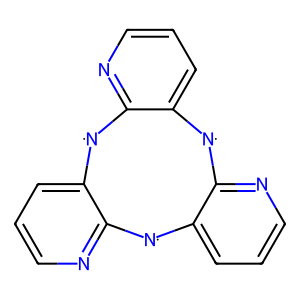

LA mol:


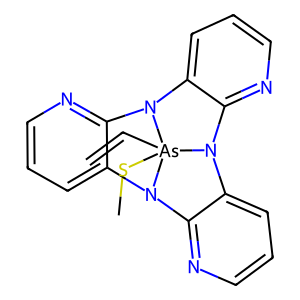

Substructure SMILES mol:


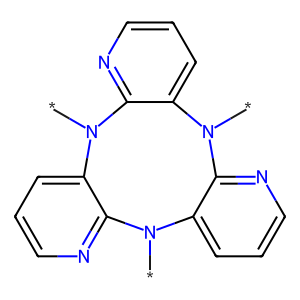

SMILES: [H]C([H])=C([H])[As]12(SC([H])([H])[H])N3c4nc([H])c([H])c([H])c4N1c1nc([H])c([H])c([H])c1N2c1nc([H])c([H])c([H])c13
Substructure SMILES: *N1c2cccnc2N(*)c2cccnc2N(*)c2cccnc21
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


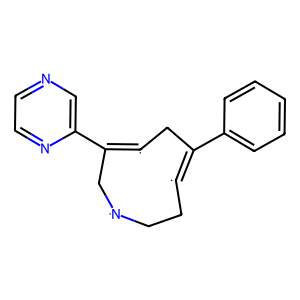

LA mol:


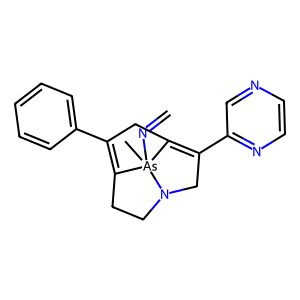

Substructure SMILES mol:


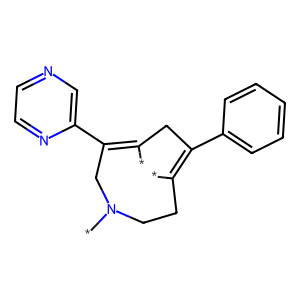

SMILES: [H]C([H])=N[As]12(C([H])([H])[H])C3=C(c4nc([H])c([H])nc4[H])C([H])([H])N1C([H])([H])C([H])([H])C2=C(c1c([H])c([H])c([H])c([H])c1[H])C3([H])[H]
Substructure SMILES: */C1=C(/c2ccccc2)C/C(*)=C(\c2cnccn2)CN(*)CC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


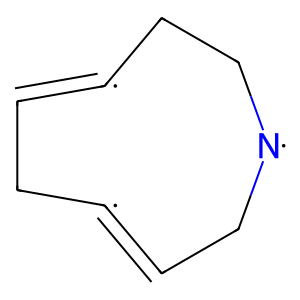

LA mol:


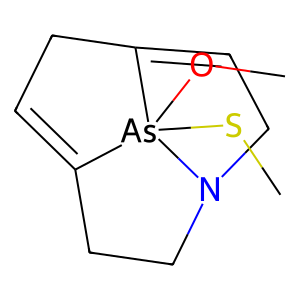

Substructure SMILES mol:


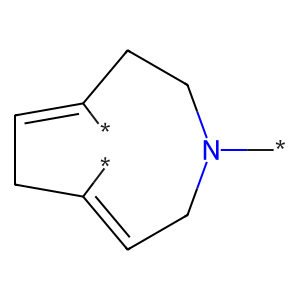

SMILES: [H]C1=C2C([H])([H])C([H])([H])N3C([H])([H])C([H])=C(C1([H])[H])[As]23(OC([H])([H])[H])SC([H])([H])[H]
Substructure SMILES: */C1=C\CN(*)CC/C(*)=C/C1


 12%|████████████████                                                                                                                  | 5556/44877 [00:12<02:15, 291.19it/s]

------------------------------------------------------------------------------------------------
No match!
Ligand mol:


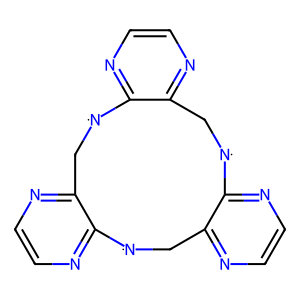

LA mol:


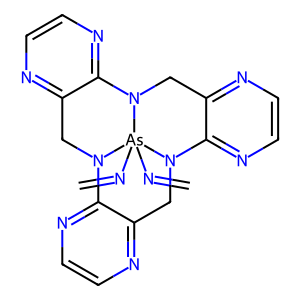

Substructure SMILES mol:


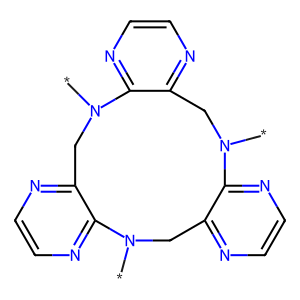

SMILES: [H]C([H])=N[As]12(N=C([H])[H])N3c4nc([H])c([H])nc4C([H])([H])N1c1nc([H])c([H])nc1C([H])([H])N2c1nc([H])c([H])nc1C3([H])[H]
Substructure SMILES: *N1Cc2nccnc2N(*)Cc2nccnc2N(*)Cc2nccnc21


 13%|████████████████▍                                                                                                                 | 5678/44877 [00:12<01:51, 353.13it/s]

------------------------------------------------------------------------------------------------
No match!
Ligand mol:


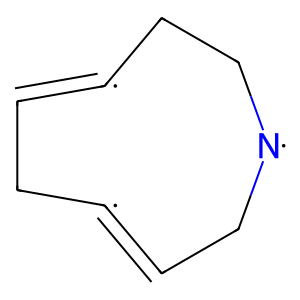

LA mol:


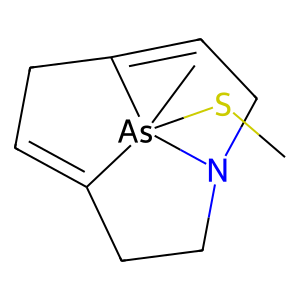

Substructure SMILES mol:


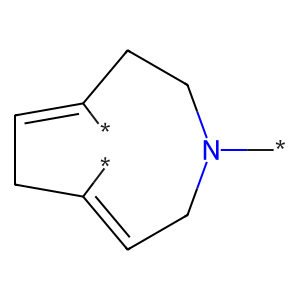

SMILES: [H]C1=C2C([H])([H])C([H])([H])N3C([H])([H])C([H])=C(C1([H])[H])[As]23(SC([H])([H])[H])C([H])([H])[H]
Substructure SMILES: */C1=C\CN(*)CC/C(*)=C/C1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


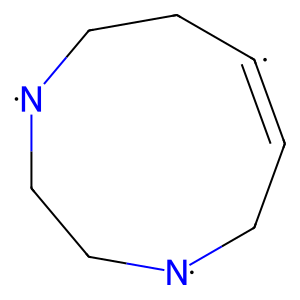

LA mol:


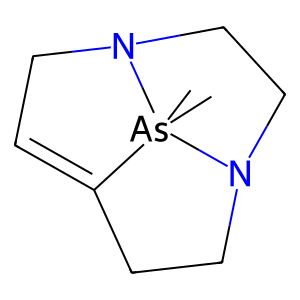

Substructure SMILES mol:


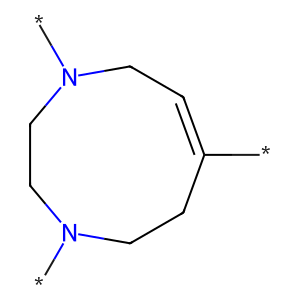

SMILES: [H]C1=C2C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])N(C1([H])[H])[As]23(C([H])([H])[H])C([H])([H])[H]
Substructure SMILES: */C1=C/CN(*)CCN(*)CC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


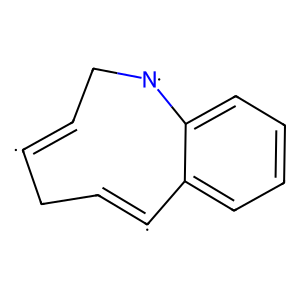

LA mol:


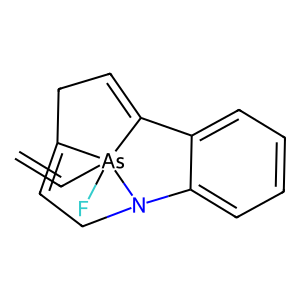

Substructure SMILES mol:


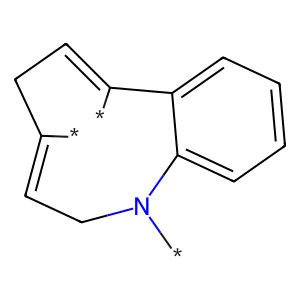

SMILES: [H]C([H])=C([H])[As]12(F)C3=C([H])C([H])([H])C1=C([H])C([H])([H])N2c1c([H])c([H])c([H])c([H])c13
Substructure SMILES: */C1=C\CN(*)c2ccccc2/C(*)=C/C1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


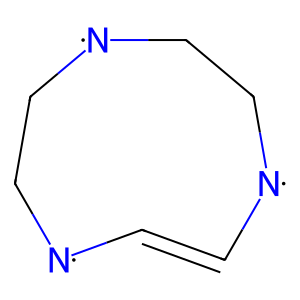

LA mol:


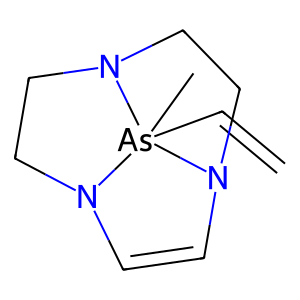

Substructure SMILES mol:


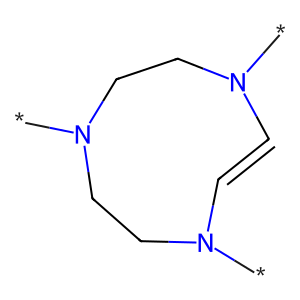

SMILES: [H]C([H])=C([H])[As]12(C([H])([H])[H])N3C([H])=C([H])N1C([H])([H])C([H])([H])N2C([H])([H])C3([H])[H]
Substructure SMILES: *N1/C=C/N(*)CCN(*)CC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


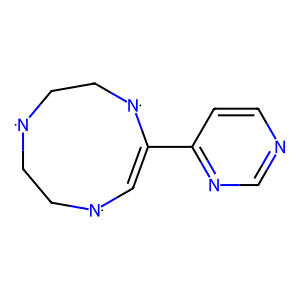

LA mol:


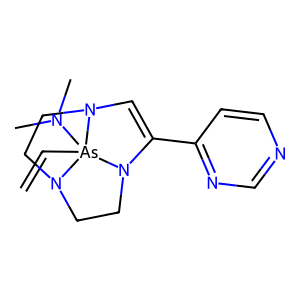

Substructure SMILES mol:


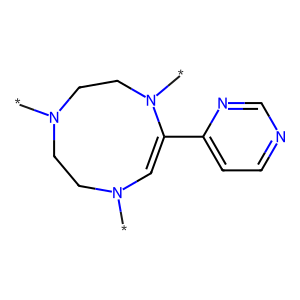

SMILES: [H]C([H])=C([H])[As]12(N(C([H])([H])[H])C([H])([H])[H])N3C([H])=C(c4nc([H])nc([H])c4[H])N1C([H])([H])C([H])([H])N2C([H])([H])C3([H])[H]
Substructure SMILES: *N1/C=C(/c2ccncn2)N(*)CCN(*)CC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


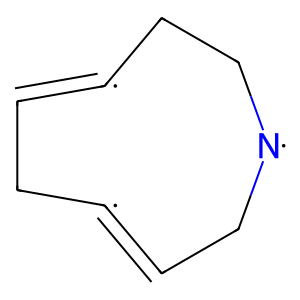

LA mol:


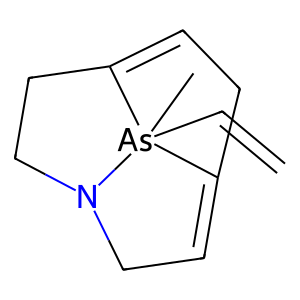

Substructure SMILES mol:


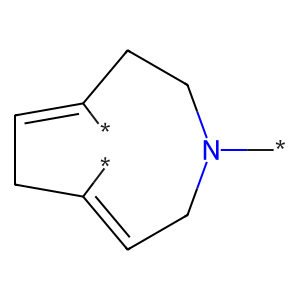

SMILES: [H]C([H])=C([H])[As]12(C([H])([H])[H])C3=C([H])C([H])([H])N1C([H])([H])C([H])([H])C2=C([H])C3([H])[H]
Substructure SMILES: */C1=C\CN(*)CC/C(*)=C/C1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


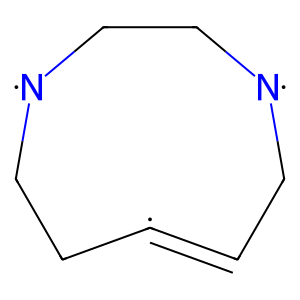

LA mol:


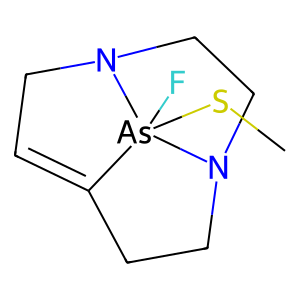

Substructure SMILES mol:


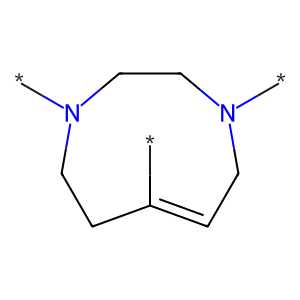

SMILES: [H]C1=C2C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])N(C1([H])[H])[As]23(F)SC([H])([H])[H]
Substructure SMILES: */C1=C\CN(*)CCN(*)CC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


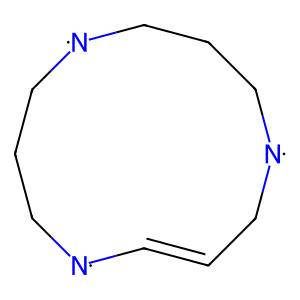

LA mol:


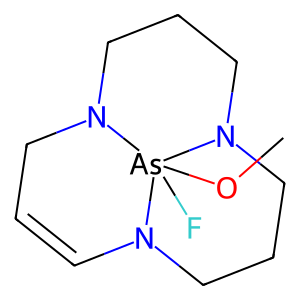

Substructure SMILES mol:


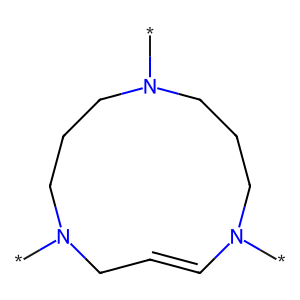

SMILES: [H]C1=C([H])C([H])([H])N2C([H])([H])C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])C([H])([H])N1[As]23(F)OC([H])([H])[H]
Substructure SMILES: *N1/C=C/CN(*)CCCN(*)CCC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


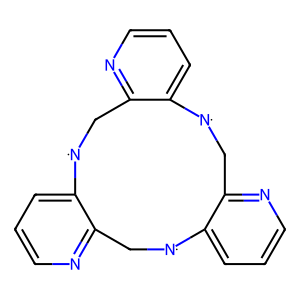

LA mol:


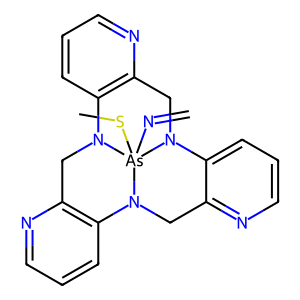

Substructure SMILES mol:


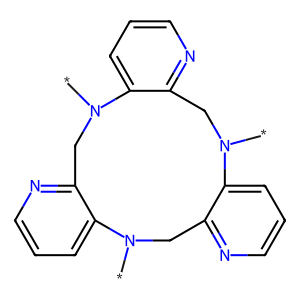

 13%|████████████████▌                                                                                                                 | 5717/44877 [00:13<02:38, 246.95it/s]

SMILES: [H]C([H])=N[As]12(SC([H])([H])[H])N3c4c(nc([H])c([H])c4[H])C([H])([H])N1c1c(nc([H])c([H])c1[H])C([H])([H])N2c1c(nc([H])c([H])c1[H])C3([H])[H]
Substructure SMILES: *N1Cc2ncccc2N(*)Cc2ncccc2N(*)Cc2ncccc21


 14%|██████████████████▎                                                                                                               | 6322/44877 [00:14<01:35, 402.76it/s]

------------------------------------------------------------------------------------------------
No match!
Ligand mol:


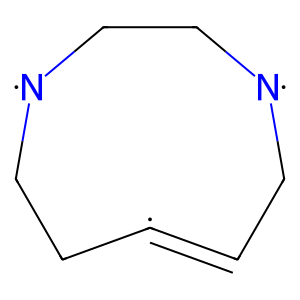

LA mol:


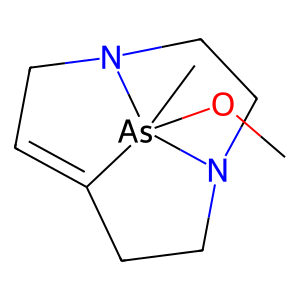

Substructure SMILES mol:


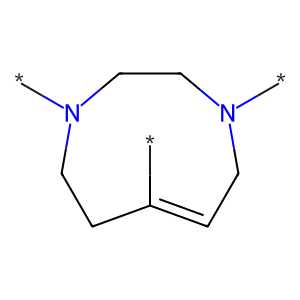

 14%|██████████████████▍                                                                                                               | 6363/44877 [00:14<01:44, 368.14it/s]

SMILES: [H]C1=C2C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])N(C1([H])[H])[As]23(OC([H])([H])[H])C([H])([H])[H]
Substructure SMILES: */C1=C\CN(*)CCN(*)CC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


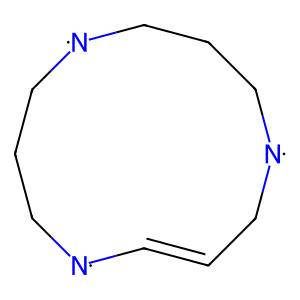

LA mol:


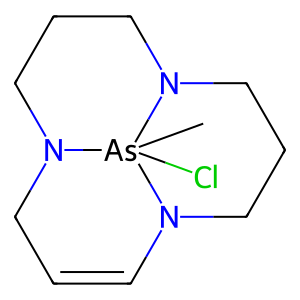

Substructure SMILES mol:


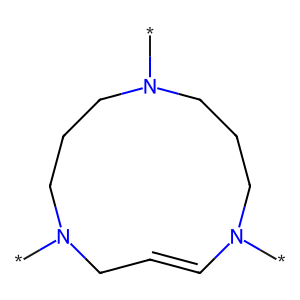

SMILES: [H]C1=C([H])C([H])([H])N2C([H])([H])C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])C([H])([H])N1[As]23(Cl)C([H])([H])[H]
Substructure SMILES: *N1/C=C/CN(*)CCCN(*)CCC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


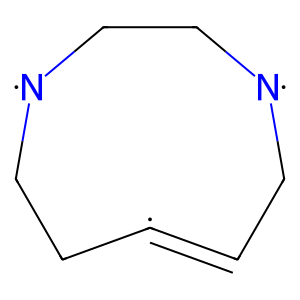

LA mol:


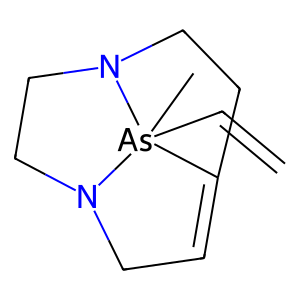

Substructure SMILES mol:


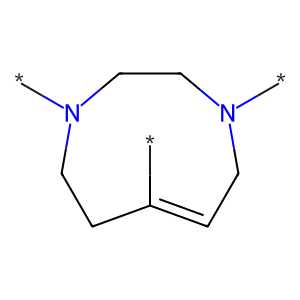

SMILES: [H]C([H])=C([H])[As]12(C([H])([H])[H])C3=C([H])C([H])([H])N1C([H])([H])C([H])([H])N2C([H])([H])C3([H])[H]
Substructure SMILES: */C1=C\CN(*)CCN(*)CC1
------------------------------------------------------------------------------------------------
No match!
Ligand mol:


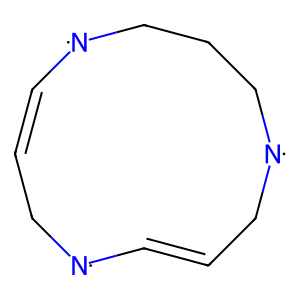

LA mol:


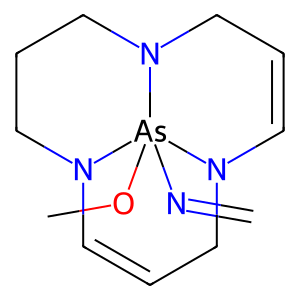

Substructure SMILES mol:


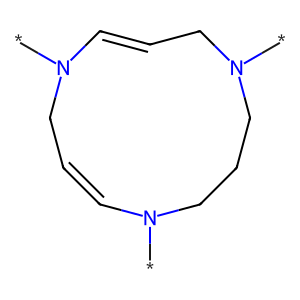

SMILES: [H]C([H])=N[As]12(OC([H])([H])[H])N3C([H])=C([H])C([H])([H])N1C([H])([H])C([H])([H])C([H])([H])N2C([H])=C([H])C3([H])[H]
Substructure SMILES: *N1/C=C\CN(*)/C=C/CN(*)CCC1


 14%|██████████████████▌                                                                                                               | 6415/44877 [00:14<01:29, 428.40it/s]


KeyboardInterrupt: 

In [4]:
radius = 1

substructures = defaultdict(lambda: [[], [], 0.])

counter = Counter({"found": 0, "not_found": 0})
# write all substructures in list:
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    smiles = row["ligand_smiles"].split(".")
    elem = substructures[row["Compound"]]
    elem[2] = row["fia_solv-PBEh3c"]
    for smi in smiles:
        sub_smiles = getSubSmilesRadN(Chem.MolFromSmiles(smi), radius)
        elem[0].extend((sub_smiles, radius))
        elem[1].extend(get_shortest_distance(sub_smiles, smi, row["ca"], row["la_smiles"], counter))
    substructures[row["Compound"]] = elem
print(counter)

with open("substructures.json", "w") as f:
    #json.dump(substructure_list, f)
    json.dump(substructures, f)

### 1.2 Draw substructures

In [21]:
# load substructure_list:
with open("substructures.json", "r") as f:
    substructures_json = json.load(f)

# count substructures and append FIA values:
#substructure_counts = defaultdict(int)
#for i in substructure_list:
#    if i:
#        substructure_counts[i] += 1

# two-tuple of list of FIAs and substructure count
substructures = defaultdict(lambda: [[], 0])
for properties in substructures_json.values():
    # these are the substructures
    for substruct in properties[0]:
        substructures[substruct][0].append(properties[1])
        substructures[substruct][1] += 1

# sort substructure_counts by counts:
substructures = dict(sorted(substructures.items(), key=lambda item: item[1][1], reverse=True))
#substructure_counts = dict(sorted(substructure_counts.items(), key=lambda item: item[1], reverse=True))

# draw substructures:
smiles = list(substructures.keys())
counts = [str(x[1]) for x in substructures.values()]
mols = [Chem.MolFromSmiles(x) for x in smiles]

num_draw_compounds = 50
#display(Chem.Draw.MolsToGridImage(mols[:num_draw_compounds], molsPerRow=10, legends=counts[:num_draw_compounds], useSVG=True, maxMols=num_draw_compounds))

substructures_highest_fia = dict(sorted(substructures.items(), key= lambda item: statistics.fmean(item[1][0]), reverse=True))

num_highest_fia = 500
min_count = 7

vals = []
labels = []
legends = []
mols = []
for i, (k, v) in enumerate(tuple(substructures_highest_fia.items())[:num_highest_fia]):
    if v[1] < min_count:
        continue
    vals.append(v[0])
    labels.append(f"Substructure {i}")
    legends.append(f"Substructure {i}: {k}\nCount: {v[1]}, Mean FIA: {statistics.fmean(v[0]):.1f}")
    mols.append(Chem.MolFromSmiles(k))

draw_boxplots(vals, labels, size = len(labels) / 2)
display(Chem.Draw.MolsToGridImage(mols, molsPerRow=6, legends=legends, useSVG=True, maxMols = len(labels)))

TypeError: unhashable type: 'list'

# 2. Analyze ring systems

### 2.1 Search for ring systems

In [9]:
ringsystems = defaultdict(lambda: [[], 0.])

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    smiles = row["ligand_smiles"].split(".")
    elem = ringsystems[row["Compound"]]
    elem[1] = row["fia_solv-PBEh3c"]
    for smi in smiles:
        elem[0].extend(getRingSystemSmiles(Chem.MolFromSmiles(smi)))

with open("ringsystem.json", "w") as f:
    json.dump(ringsystems, f)

100%|████████████████████████████████████████| 44877/44877 [00:16<00:00, 2739.85it/s]


### 2.2 Draw ringsystems

/tmp/ipykernel_3186/1758486788.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, vert = False, labels = labels)


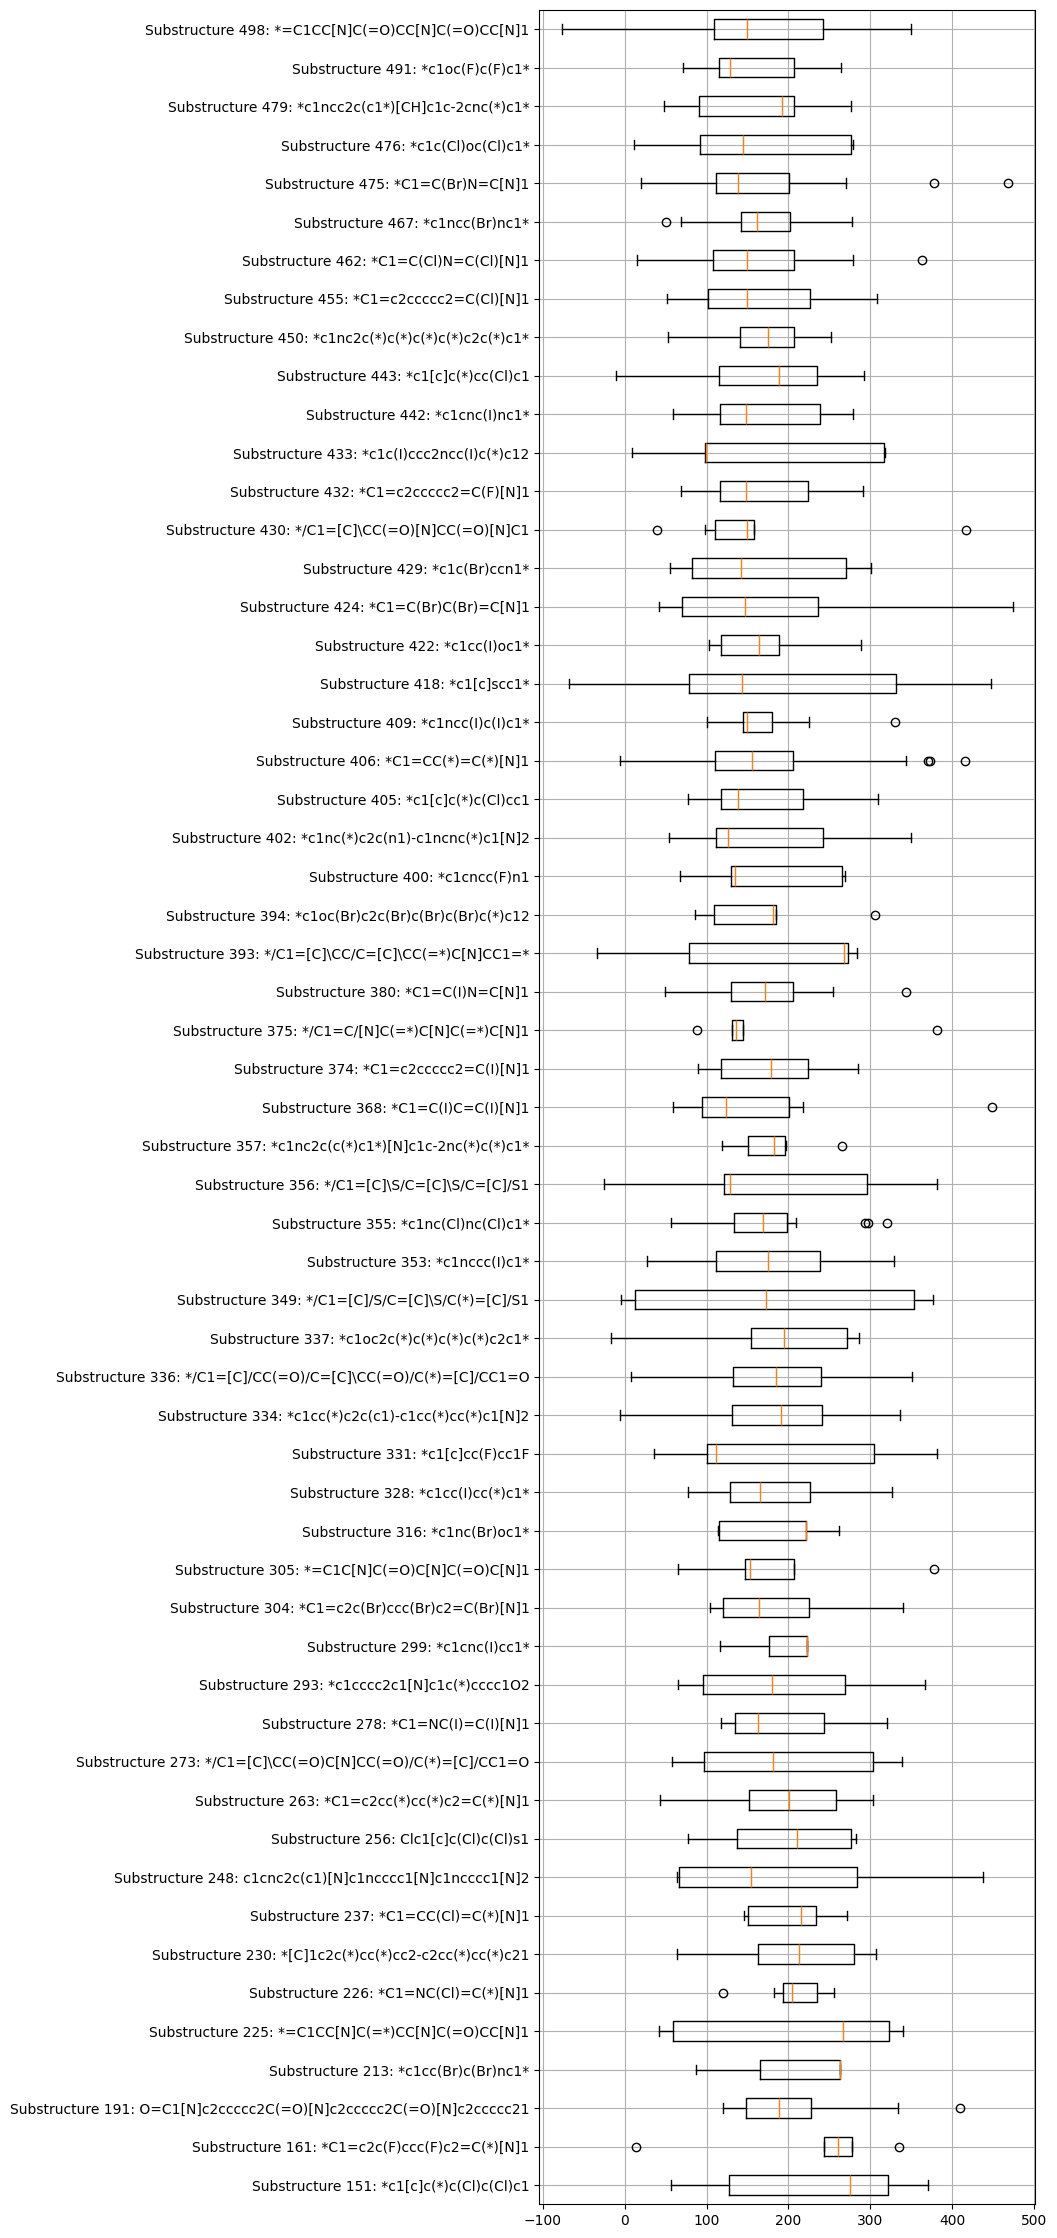

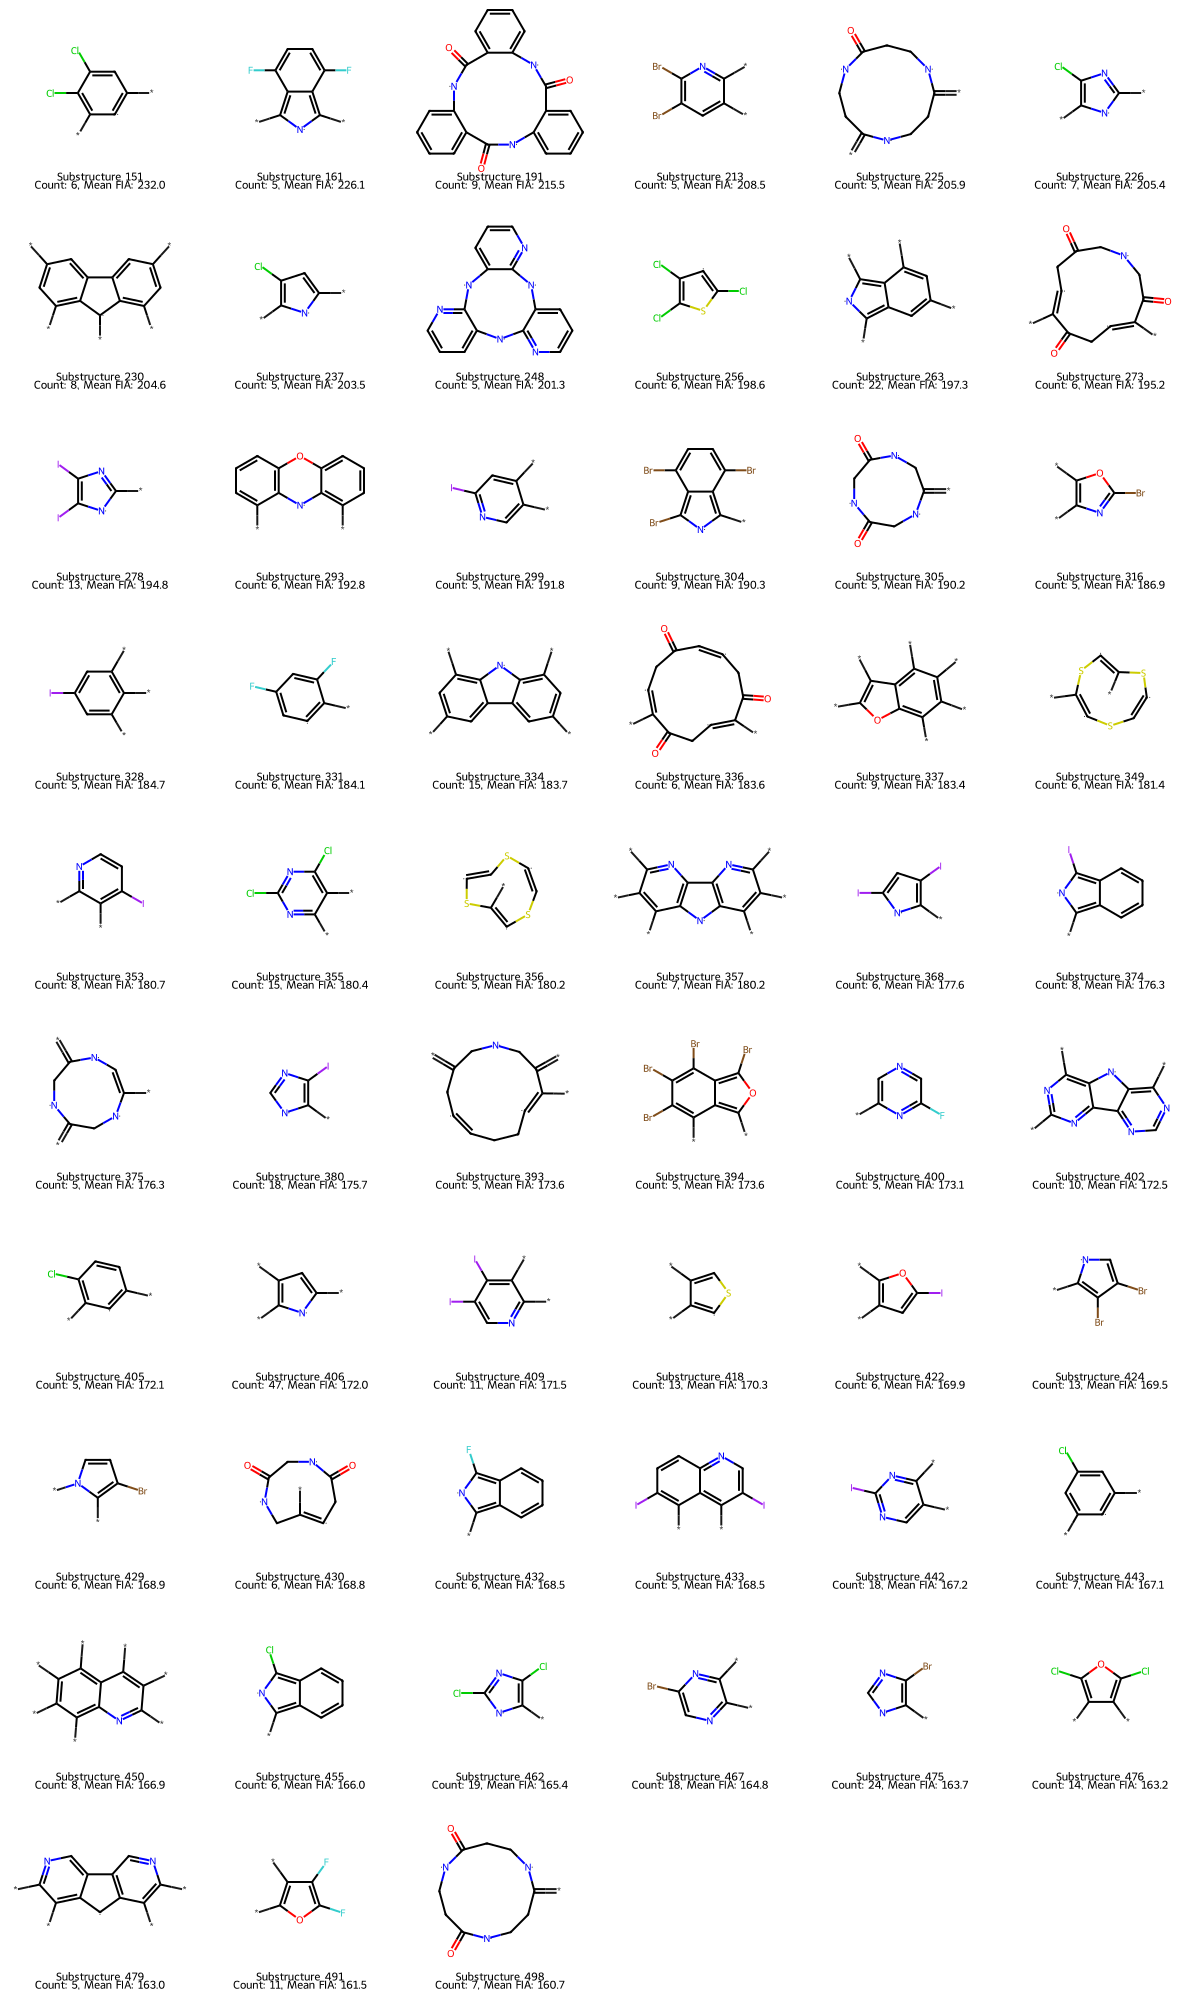

In [10]:
# load substructure_list:
with open("ringsystem.json", "r") as f:
    ringsystems_json = json.load(f)

# two-tuple of list of FIAs and ringsystem count
ringsystems = defaultdict(lambda: [[], 0])
for properties in ringsystems_json.values():
    # these are the substructures
    for substruct in properties[0]:
        ringsystems[substruct][0].append(properties[1])
        ringsystems[substruct][1] += 1

# sort substructure_counts by counts:
ringsystems = dict(sorted(ringsystems.items(), key=lambda item: item[1][1], reverse=True))

# draw substructures:
smiles = list(ringsystems.keys())
counts = [str(x[1]) for x in ringsystems.values()]
mols = [Chem.MolFromSmiles(x) for x in smiles]

num_draw_compounds = 50
#display(Chem.Draw.MolsToGridImage(mols[:num_draw_compounds], molsPerRow=10, legends=counts[:num_draw_compounds], useSVG=True, maxMols=num_draw_compounds))

ringsystems_highest_fia = dict(sorted(ringsystems.items(), key= lambda item: statistics.fmean(item[1][0]), reverse=True))

num_highest_fia = 500
min_count = 5 

vals = []
labels = []
legends = []
mols = []
for i, (k, v) in enumerate(tuple(ringsystems_highest_fia.items())[:num_highest_fia]):
    if v[1] < min_count:
        continue
    vals.append(v[0])
    labels.append(f"Substructure {i}: {k}")
    legends.append(f"Substructure {i}\nCount: {v[1]}, Mean FIA: {statistics.fmean(v[0]):.1f}")
    mols.append(Chem.MolFromSmiles(k))

draw_boxplots(vals, labels, size = len(labels) / 2)
display(Chem.Draw.MolsToGridImage(mols, molsPerRow=6, legends=legends, useSVG=True, maxMols = len(labels)))